# Général

In [ ]:
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import csv
import pandas as pd
import seaborn as sns
import networkx as nx
from itertools import combinations


# Analyse Exploratoire de Données (Text)

### Contenu du dossier `Flickr8k_text`

| Nom du fichier               | Description |
|-----------------------------|-------------|
| **`crowdFlowerAnnotations`** | Annotations supplémentaires venant de **crowdsourcing** (plateforme CrowdFlower). Peut contenir des scores, labels ou préférences humains. |
| **`expertAnnotations`**      | Annotations ou jugements faits par des **experts linguistes ou vision** (qualité des légendes, correspondance, etc.). |
| **`flickr_8k.devImage`**     | Liste des **images de validation (dev)**. Chaque ligne est un nom de fichier `.jpg`. |
| **`flickr_8k.testImage`**    | Liste des **images de test**. Même format que ci-dessus. |
| **`flickr_8k.trainImage`**   | Liste des **images d'entraînement**. Pareil. |
| **`flickr_8k.lemma`**        | Version **lemmatisée** des descriptions (forme de base des mots : *"running"* → *"run"*). Peut servir pour des analyses de vocabulaire propres. |
| **`flickr_8k.token`**        | Fichier contenant les **descriptions textuelles originales** du dataset. Format : `image.jpg#0 <tab> description`. Il y a **5 descriptions par image**. |


### EDA flickr_8k.token

In [129]:
fichier_token = '../data/raw/Flickr8k_text/Flickr8k.token.txt'

In [130]:
#Charger et parser le fichier
descriptions = defaultdict(list)  #clé=image.jpg, valeur=list de descriptions

with open(fichier_token, 'r', encoding='utf-8') as f:
    for ligne in f:
        ligne = ligne.strip()
        if not ligne:
            continue

        #Format : image.jpg#0 <tab> description
        cle, desc = ligne.split('\t')
        image_id = cle.split('#')[0]
        descriptions[image_id].append(desc)

#Nombre total de descriptions
total_desc = sum(len(lst) for lst in descriptions.values())
print(f"Nombre total de descriptions : {total_desc}")

#Nombre d'images uniques
total_images = len(descriptions)
print(f"Nombre total d'images : {total_images}")

#Vérifier nombre moyen de descriptions par image
desc_par_image = [len(lst) for lst in descriptions.values()]
print(f"Descriptions par image : min={min(desc_par_image)}, max={max(desc_par_image)}, moyenne={sum(desc_par_image)/total_images:.2f}")

#Analyse des longueurs en mots
longueurs = [len(desc.split()) for lst in descriptions.values() for desc in lst]
print(f"Longueur des descriptions en mots : min={min(longueurs)}, max={max(longueurs)}, moyenne={sum(longueurs)/len(longueurs):.2f}")

#Calculer vocabulaire
mots = [mot for lst in descriptions.values() for desc in lst for mot in desc.split()]
vocabulaire = set(mots)
print(f"Taille du vocabulaire (mots uniques) : {len(vocabulaire)}")

#Afficher 5 images avec leurs descriptions
print("\nExemples de descriptions :")
for i, (img_id, descs) in enumerate(list(descriptions.items())[:5]):
    print(f"\n{img_id} :")
    for d in descs:
        print(f" - {d}")

Nombre total de descriptions : 40460
Nombre total d'images : 8092
Descriptions par image : min=5, max=5, moyenne=5.00
Longueur des descriptions en mots : min=1, max=38, moyenne=11.78
Taille du vocabulaire (mots uniques) : 9630

Exemples de descriptions :

1000268201_693b08cb0e.jpg :
 - A child in a pink dress is climbing up a set of stairs in an entry way .
 - A girl going into a wooden building .
 - A little girl climbing into a wooden playhouse .
 - A little girl climbing the stairs to her playhouse .
 - A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg :
 - A black dog and a spotted dog are fighting
 - A black dog and a tri-colored dog playing with each other on the road .
 - A black dog and a white dog with brown spots are staring at each other in the street .
 - Two dogs of different breeds looking at each other on the road .
 - Two dogs on pavement moving toward each other .

1002674143_1b742ab4b8.jpg :
 - A little girl covered in paint sits in 

### EDA Flickr8k.lemma.token

# 📄 Structure du fichier `Flickr8k.lemma.token`

Le fichier `Flickr8k.lemma.token` contient les légendes associées aux images du jeu de données **Flickr8k**, dans une version **lemmatisée** (chaque mot est ramené à sa forme de base) et **tokenisée** (chaque mot est séparé par un espace).


## 🔧 Format général

| Élément              | Description                                                                 |
|----------------------|-----------------------------------------------------------------------------|
| **Nom du fichier**   | `Flickr8k.lemma.token`                                                      |
| **Type de fichier**  | Texte brut (.txt)                                                           |
| **Encodage**         | UTF-8                                                                       |
| **Séparateur**       | Tabulation (`\t`) entre l'identifiant d'image et la légende                 |
| **Lignes totales**   | Environ 40 000 lignes (8 000 images × 5 légendes par image)                 |


## 🧱 Structure d'une ligne

```text
image_id.jpg#caption_number<TAB>lemmatised_caption


### 📊 Interprétation des statistiques du corpus

#### 1. Structure du dataset

| Statistique                          | Valeur                         |
|-------------------------------------|--------------------------------|
| Nombre total de descriptions        | 40 460                         |
| Nombre total d’images               | 8 092                          |
| Descriptions par image              | Min: 5, Max: 5, Moyenne: 5.00  |
| Longueur des descriptions (mots)    | Min: 1, Max: 38, Moyenne: 11.78|
| Taille du vocabulaire unique        | 9 630 mots                     |

---

#### 2. Commentaires et interprétation

✅ **Dataset équilibré**  
Chaque image possède exactement **5 descriptions**, ce qui est idéal pour l'entraînement de modèles de génération de texte (*LSTM*, *Transformer*, etc.).


🧠 **Richesse du langage**  
- La **longueur moyenne de 11.78 mots par phrase** montre des descriptions courtes mais informatives.  
- Une **variabilité entre 1 et 38 mots** suggère une diversité importante dans le style des captions, ce qui est favorable à l'entraînement d’un modèle génératif robuste.


📚 **Vocabulaire large mais raisonnable**  
- **9 630 mots différents** : un vocabulaire riche mais encore traitable.  
- Cela permet d’envisager un **tokeniseur** ou une stratégie de *vocabulary trimming* sans réduction trop agressive.

---

#### 🔧 Stratégies recommandées

#### 1. Nettoyage minimal (préprocessing)
- Tokenisation simple (avec `nltk`, `spacy` ou un tokenizer type BERT)
- Passage en minuscules
- Suppression de la ponctuation si nécessaire (selon le modèle utilisé)


#### 2. Construction du vocabulaire
- Garder les **N mots les plus fréquents** (ex. top 5 000) pour limiter l'espace mémoire
- Remplacer les mots rares par `<UNK>` (token pour mot inconnu)


#### 3. Entraînement du modèle
- 🔁 **Entrée** : image encodée via un CNN (ex. ResNet, VGG)
- 🧠 **Sortie** : description générée **mot par mot** (LSTM ou Transformer)
- 🚀 **Optimisation** : loss par **cross-entropy** ou avec **teacher forcing**


#### 4. Utilisation pour génération ou évaluation
- Générer des **captions pour des images inédites**
- Évaluer avec des métriques standard : **BLEU**, **METEOR**, **CIDEr**, etc.


In [176]:
fichier_lemma = "../data/raw/Flickr8k_text/Flickr8k.lemma.token.txt"

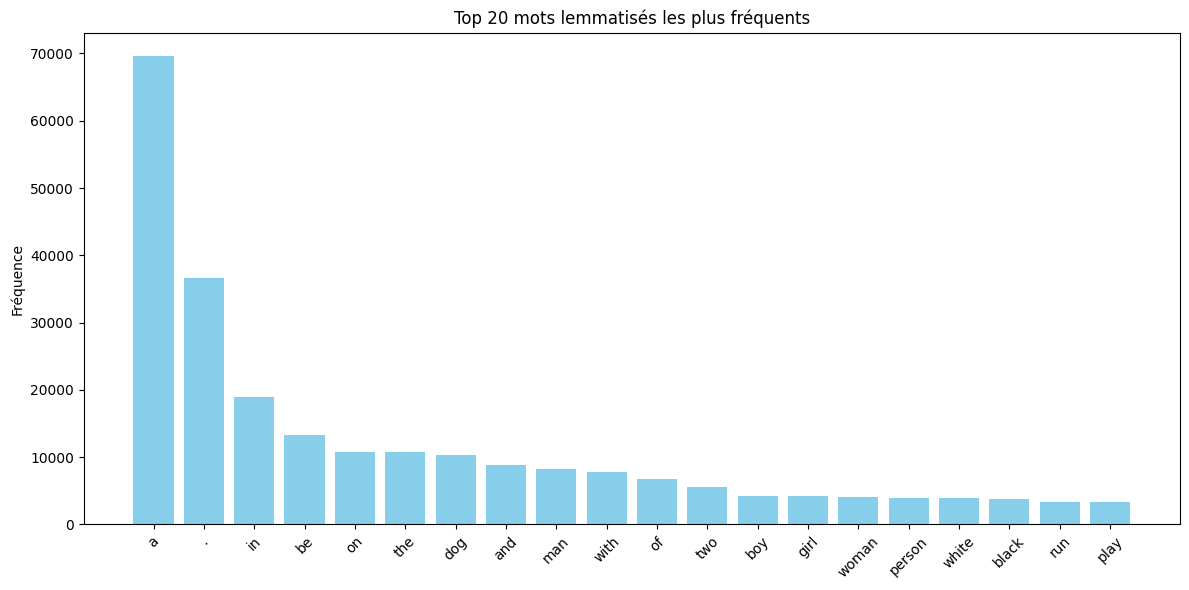

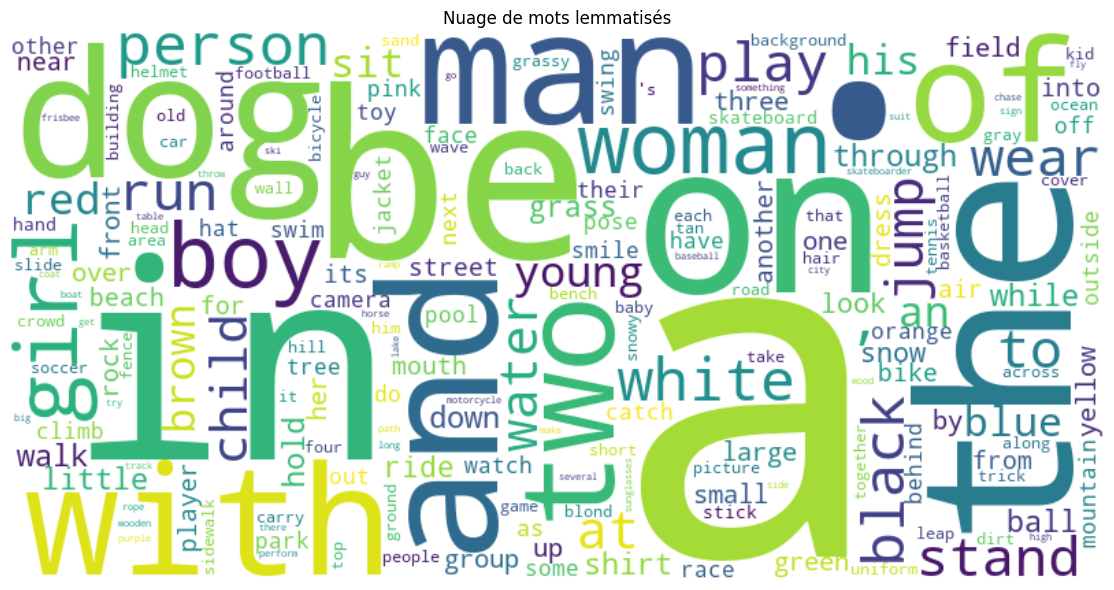

/var/folders/3h/mjz6y8bs7s5dm1wmx83nl0nm0000gn/T/ipykernel_3086/1488648765.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


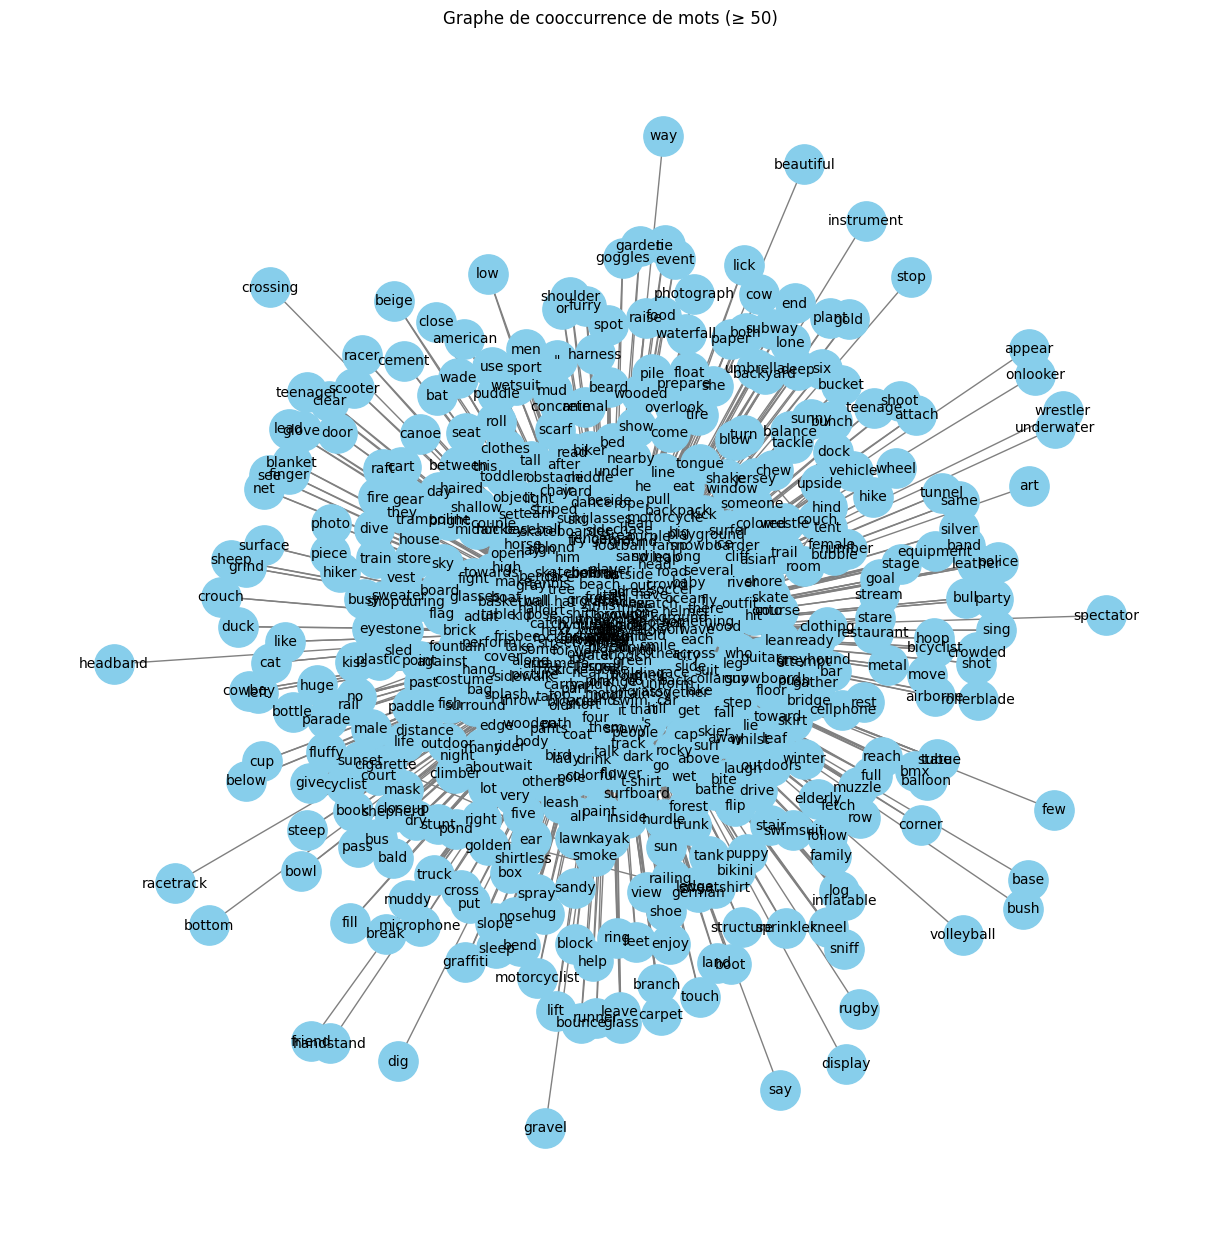

In [ ]:
#Lecture du fichier
with open(fichier_lemma, 'r', encoding='utf-8') as f:
    lines = f.readlines()

captions = []
image_to_words = defaultdict(list)

#Nettoyage et séparation
for line in lines:
    img_id, caption = line.strip().split('\t')
    words = caption.lower().split()
    captions.append(words)
    image = img_id.split('#')[0]
    image_to_words[image].extend(words)

#1. Histogramme de fréquence des mots
word_counts = Counter([word for caption in captions for word in caption])
top_words = word_counts.most_common(20)
words, counts = zip(*top_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 mots lemmatisés les plus fréquents')
plt.xticks(rotation=45)
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

#2. Nuage de mots
wc = WordCloud(width=800, height=400, background_color='white')
wc.generate_from_frequencies(word_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots lemmatisés')
plt.tight_layout()
plt.show()

#3. Graphe de cooccurrence de mots
G = nx.Graph()
cooc_counts = Counter()

for caption in captions:
    for w1, w2 in combinations(set(caption), 2): 
        pair = tuple(sorted([w1, w2]))
        cooc_counts[pair] += 1

#Ajouter les arêtes ayant au moins 50 cooccurrences
for (w1, w2), weight in cooc_counts.items():
    if weight >= 50:
        G.add_edge(w1, w2, weight=weight)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=800, font_size=10)
plt.title('Graphe de cooccurrence de mots (≥ 50)')
plt.tight_layout()
plt.show()


Nombre total de descriptions : 40460
Nombre total d'images : 8092
Descriptions par image : min=5, max=5, moyenne=5.00
Longueur des descriptions en mots : min=1, max=38, moyenne=11.78
Taille du vocabulaire (mots uniques) : 9630


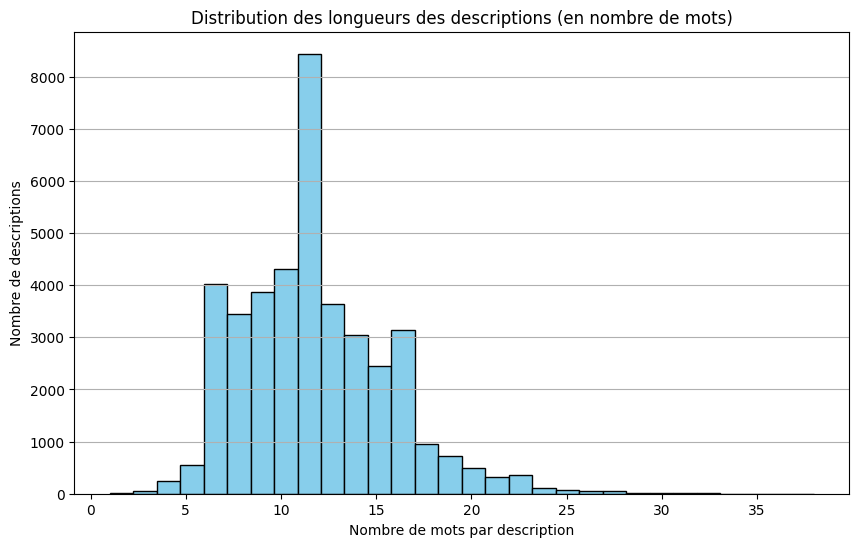

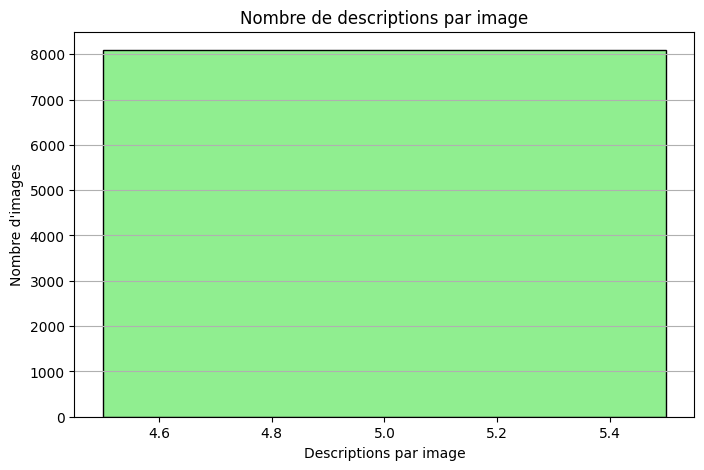

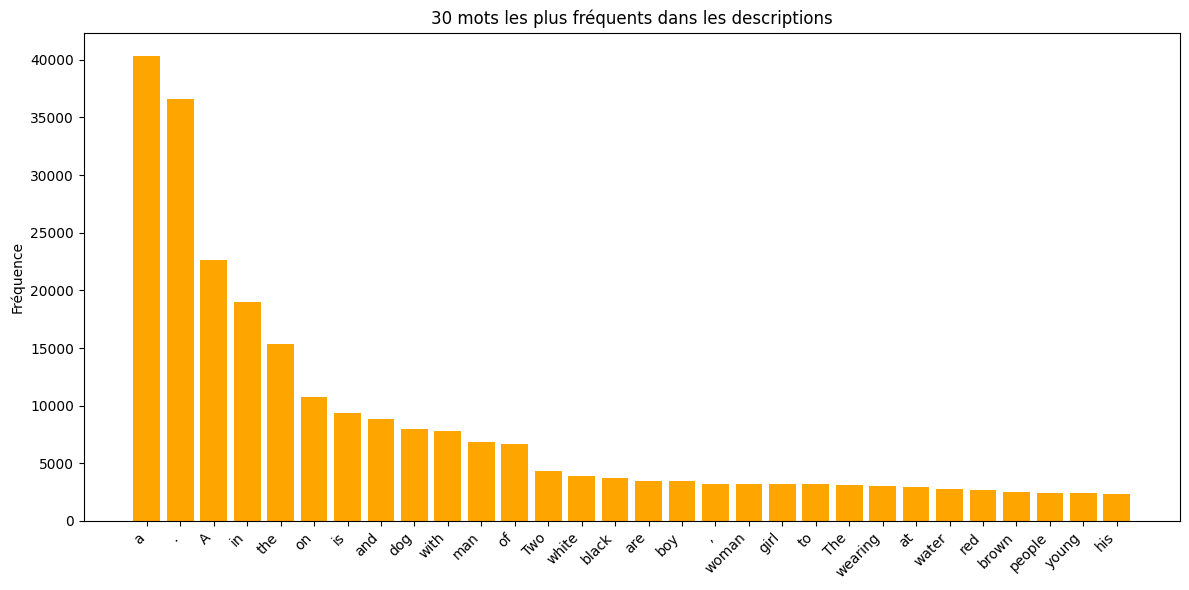

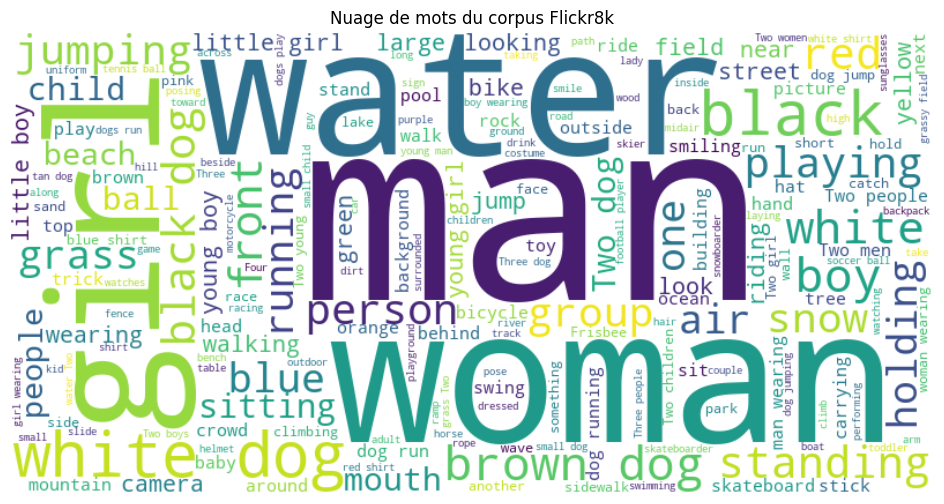

In [178]:
descriptions = defaultdict(list)  #clé=image.jpg, valeur=list de descriptions

with open(fichier_token, 'r', encoding='utf-8') as f:
    for ligne in f:
        ligne = ligne.strip()
        if not ligne:
            continue
        cle, desc = ligne.split('\t')
        image_id = cle.split('#')[0]
        descriptions[image_id].append(desc)

#Statistiques de base

total_desc = sum(len(lst) for lst in descriptions.values())
total_images = len(descriptions)
desc_par_image = [len(lst) for lst in descriptions.values()]
longueurs = [len(desc.split()) for lst in descriptions.values() for desc in lst]
mots = [mot for lst in descriptions.values() for desc in lst for mot in desc.split()]
vocabulaire = set(mots)

print(f"Nombre total de descriptions : {total_desc}")
print(f"Nombre total d'images : {total_images}")
print(f"Descriptions par image : min={min(desc_par_image)}, max={max(desc_par_image)}, moyenne={sum(desc_par_image)/total_images:.2f}")
print(f"Longueur des descriptions en mots : min={min(longueurs)}, max={max(longueurs)}, moyenne={sum(longueurs)/len(longueurs):.2f}")
print(f"Taille du vocabulaire (mots uniques) : {len(vocabulaire)}")

#Graphiques

#1. Histogramme des longueurs de descriptions (en mots)
plt.figure(figsize=(10,6))
plt.hist(longueurs, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution des longueurs des descriptions (en nombre de mots)")
plt.xlabel("Nombre de mots par description")
plt.ylabel("Nombre de descriptions")
plt.grid(axis='y')
plt.show()

#2. Histogramme du nombre de descriptions par image
plt.figure(figsize=(8,5))
plt.hist(desc_par_image, bins=range(min(desc_par_image), max(desc_par_image)+2), color='lightgreen', edgecolor='black', align='left')
plt.title("Nombre de descriptions par image")
plt.xlabel("Descriptions par image")
plt.ylabel("Nombre d'images")
plt.grid(axis='y')
plt.show()

#3. Bar plot des 30 mots les plus fréquents
compte_mots = Counter(mots)
mots_les_plus_frequents = compte_mots.most_common(30)
mots_labels, mots_counts = zip(*mots_les_plus_frequents)

plt.figure(figsize=(12,6))
plt.bar(mots_labels, mots_counts, color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("30 mots les plus fréquents dans les descriptions")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

#4. Nuage de mots (word cloud)
texte_total = ' '.join(mots)
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texte_total)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots du corpus Flickr8k")
plt.show()


### EDA flickr_8k.devImage / EDA flickr_8k.testImage / EDA flickr_8k.trainImage

In [179]:
dossier_texte = '../data/raw/Flickr8k_text'

In [180]:
def lire_fichier_liste_images(nom_fichier):
    with open(os.path.join(dossier_texte, nom_fichier), 'r') as f:
        lignes = f.read().strip().split('\n')
    return set(lignes)

train_images = lire_fichier_liste_images('Flickr_8k.trainImages.txt')
dev_images = lire_fichier_liste_images('Flickr_8k.devImages.txt')
test_images = lire_fichier_liste_images('Flickr_8k.testImages.txt')

print(f"Nombre d'images train : {len(train_images)}")
print(f"Nombre d'images dev : {len(dev_images)}")
print(f"Nombre d'images test : {len(test_images)}")

# Vérifier chevauchements
print(f"Chevauchement train-dev : {len(train_images.intersection(dev_images))}")
print(f"Chevauchement train-test : {len(train_images.intersection(test_images))}")
print(f"Chevauchement dev-test : {len(dev_images.intersection(test_images))}")

# Vérifier couverture totale
total_images_split = len(train_images.union(dev_images).union(test_images))
print(f"Total images dans splits : {total_images_split}")


Nombre d'images train : 6000
Nombre d'images dev : 1000
Nombre d'images test : 1000
Chevauchement train-dev : 0
Chevauchement train-test : 0
Chevauchement dev-test : 0
Total images dans splits : 8000


#### 📊 Répartition des jeux de données (Flickr8k)

| Split         | Nombre d'images |
|---------------|-----------------|
| Entraînement  | 6 000           |
| Validation    | 1 000           |
| Test          | 1 000           |
| **Total**     | 8 000           |

✅ **Aucun chevauchement** entre les ensembles :
- **Train ∩ Dev = 0**
- **Train ∩ Test = 0**
- **Dev ∩ Test = 0**

Cela garantit une séparation stricte pour l’évaluation, utile pour tester la capacité de généralisation des modèles.

---

#### 🧩 Implications de la répartition des jeux de données

- 🔒 **Séparation stricte** entre les ensembles : cela permet de mesurer correctement la capacité de généralisation d’un modèle.
  
- 🧪 **Évaluation fiable** : les performances obtenues sur le jeu de test reflètent bien le comportement du modèle sur des images **jamais vues**.

- 🧠 **Validation utile** : le jeu de validation (dev) permet de régler les hyperparamètres sans sur-entraîner sur le test.

- 🔁 **Reproductibilité assurée** : aucun mélange entre les splits évite les fuites de données et garantit des expériences comparables.

---

#### 🧠 Stratégies basées sur la répartition des données

### 1. Utilisation des splits
- **Entraînement** : utiliser uniquement les 6 000 images du split *train* pour ajuster les poids du modèle.
- **Validation** : surveiller les performances sur *dev* pour l’ajustement d’hyperparamètres et le early stopping.
- **Test** : ne jamais utiliser le split *test* pendant l’entraînement → réservé à l’évaluation finale.

### 2. Bonnes pratiques
- Vérifier systématiquement qu’aucune image ne se répète entre les splits.
- Toujours évaluer sur un split *non vu* pour garantir une mesure de généralisation.
- Option : faire une cross-validation sur d'autres datasets si la taille le permet, mais ici la séparation stricte suffit.

### 3. Intégration dans les pipelines
- Charger et encoder séparément chaque split.
- Stocker les embeddings ou les features de chaque ensemble dans des fichiers distincts pour éviter les confusions.
---

In [181]:
#Charger les descriptions depuis le fichier token
descriptions_par_image = defaultdict(list)
with open(fichier_token, 'r') as f:
    for ligne in f:
        #Format : image.jpg#0 <tab> description
        img_desc = ligne.strip().split('\t')
        if len(img_desc) == 2:
            image_nom = img_desc[0].split('#')[0]
            description = img_desc[1]
            descriptions_par_image[image_nom].append(description)

#Vérifier que toutes les images des splits ont 5 descriptions
def verifier_descriptions(images_split, nom_split):
    manquantes = [img for img in images_split if img not in descriptions_par_image]
    print(f"{nom_split} : {len(images_split)} images")
    print(f" - Images sans descriptions : {len(manquantes)}")
    
    #Images avec nombre de descriptions != 5
    mauvais_nombre = [img for img in images_split if len(descriptions_par_image.get(img, [])) != 5]
    print(f" - Images avec un nombre de descriptions différent de 5 : {len(mauvais_nombre)}")
    if mauvais_nombre:
        print("Exemples : ", mauvais_nombre[:5])
    print()

#Tester pour chaque split
verifier_descriptions(train_images, "Train")
verifier_descriptions(dev_images, "Dev")
verifier_descriptions(test_images, "Test")

#Vérifier si des images dans descriptions n'appartiennent à aucun split
images_avec_descriptions = set(descriptions_par_image.keys())
images_tous_splits = train_images.union(dev_images).union(test_images)
images_non_repertoriees = images_avec_descriptions - images_tous_splits
print(f"Images présentes dans les descriptions mais pas dans les splits : {len(images_non_repertoriees)}")
if images_non_repertoriees:
    print("Exemples : ", list(images_non_repertoriees)[:5])


Train : 6000 images
 - Images sans descriptions : 0
 - Images avec un nombre de descriptions différent de 5 : 0

Dev : 1000 images
 - Images sans descriptions : 0
 - Images avec un nombre de descriptions différent de 5 : 0

Test : 1000 images
 - Images sans descriptions : 0
 - Images avec un nombre de descriptions différent de 5 : 0

Images présentes dans les descriptions mais pas dans les splits : 92
Exemples :  ['2838085973_42b6e9b5b1.jpg', '843616798_5ab0ecb525.jpg', '3736786640_70df13be2c.jpg', '2973269132_252bfd0160.jpg', '2616508003_fa5ca5780d.jpg']


#### 📊 Vérification des descriptions par split

#### 1. Vérification par split
Chaque image dans le dataset devrait avoir **exactement 5 descriptions**.

| Split      | Images dans le split | Sans description | ≠ 5 descriptions |
|------------|----------------------|------------------|------------------|
| Train      | 6 000                | 0                | 0                |
| Dev        | 1 000                | 0                | 0                |
| Test       | 1 000                | 0                | 0                |

✅ Toutes les images dans chaque split possèdent bien **5 captions**.


#### 2. Images hors splits

- Nombre d’images présentes dans les descriptions mais absentes de tous les splits : **92**
- Exemple d’images "non utilisées" : `['2258277193_586949ec62.jpg', '2433442190_bf7a24f108.jpg', ...]`

Ces images existent dans `Flickr8k.token.txt` mais **ne sont pas assignées à train/dev/test**.

---


#### 🧩 Implications des vérifications

- ✅ **Intégrité des splits assurée** : aucune image de train, dev ou test n’est incomplète — chaque image possède exactement 5 captions, ce qui est parfait pour un entraînement supervisé robuste.

- 🧠 **Images non assignées détectées** :
  - 92 images présentes dans `Flickr8k.token.txt` ne sont pas utilisées dans les splits.
  - Ces images peuvent être ignorées ou exploitées dans des tâches annexes (ex. : évaluation qualitative, debug, visualisation...).

- 🔐 **Dataset prêt à l’usage** :
  - Pas besoin de nettoyage ou de correction supplémentaire pour la partie `captioning`.

---

#### 🧠 Stratégies recommandées après validation des descriptions

#### 1. Préparation des données
- Utiliser exclusivement les images des splits **train/dev/test** → garantir la reproductibilité et l’équité de l’évaluation.
- Ignorer les 92 images "hors splits" sauf pour analyse secondaire ou debug.

#### 2. Pipeline d’entraînement
- Charger uniquement les images qui ont exactement 5 captions.
- Vérifier dynamiquement en pipeline que toutes les images en entrée sont bien couvertes par leurs descriptions.

#### 3. Bonnes pratiques
- Toujours vérifier la cohérence entre fichiers `.txt` (captions) et les splits fournis.
- Documenter ce nettoyage dans un `README` pour faciliter la maintenance du code et la réutilisation par d’autres.

✅ Ce type de validation est **essentiel avant tout entraînement** pour éviter des erreurs silencieuses et des biais d’évaluation.

---

### EDA CrowdFlowerAnnotations

### Analyse du fichier `CrowdFlowerAnnotations.txt`

Ce fichier contient les **annotations issues de la plateforme de crowdsourcing CrowdFlower**.  
Il est utilisé pour évaluer si une **légende (caption)** correspond bien à une **image** donnée, selon des jugements humains.

### Structure du fichier

Chaque ligne contient 5 colonnes séparées par une tabulation (`\t`) :

| Colonne | Description |
|---------|-------------|
| `0` | **Nom de l’image** – l’image cible à décrire (ex: `1056338697_4f7d7ce270.jpg`) |
| `1` | **Identifiant de la légende** – combinaison de l’image source et d’un index (ex: `1056338697_4f7d7ce270.jpg#2`) |
| `2` | **Pourcentage de "Yes"** – proportion des annotateurs qui estiment que la légende décrit l’image |
| `3` | **Nombre de "Yes"** – nombre d'annotateurs ayant répondu **Yes** |
| `4` | **Nombre de "No"** – nombre d'annotateurs ayant répondu **No** |


> ✔️ Un **"Yes"** signifie que la légende **décrit correctement l’image**, même avec de légères erreurs.  
> ❌ Un **"No"** signifie que la légende **ne décrit pas** l’image.  

Chaque paire image-légende a reçu **au minimum 3 annotations**, parfois plus.

### 🎯 À quoi ça sert ?

Ce fichier peut être utilisé pour :

- Évaluer automatiquement la **qualité des descriptions générées** par des modèles,
- Construire un sous-ensemble de légendes **jugées valides par des humains**,
- Comparer des légendes concurrentes et sélectionner la **meilleure selon le consensus humain**.

---




### En résumé

| Colonne        | Description |
|----------------|-------------|
| `image`        | Nom de l’image évaluée |
| `caption_id`   | Identifiant de la légende (image + index, ex. `xxx.jpg#2`) |
| `percent_yes`  | Pourcentage de votes "Oui" (légende correcte selon les annotateurs) |
| `yes_votes`    | Nombre total de "Oui" |
| `no_votes`     | Nombre total de "Non" |

🔎 **Interprétation** :
- Chaque ligne représente une évaluation d’une *légende candidate* pour une image.
- Jugée par plusieurs annotateurs (crowdsourcing).
- Utile pour mesurer **la qualité perçue** des descriptions proposées.
- Un `percent_yes` proche de 1 indique une **bonne correspondance image-description**.

---

In [182]:
chemin_fichier_annot_people = '../data/raw/Flickr8k_text/CrowdFlowerAnnotations.txt'

In [183]:
with open(chemin_fichier_annot_people, 'r', encoding='utf-8') as f:
    for i in range(10):
        print(f.readline().strip())

1056338697_4f7d7ce270.jpg	1056338697_4f7d7ce270.jpg#2	1	3	0
1056338697_4f7d7ce270.jpg	114051287_dd85625a04.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	1427391496_ea512cbe7f.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2073964624_52da3a0fc4.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2083434441_a93bc6306b.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2204550058_2707d92338.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2224450291_4c133fabe8.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2248487950_c62d0c81a9.jpg#2	0.333333333333333	1	2
1056338697_4f7d7ce270.jpg	2307118114_c258e3a47e.jpg#2	0	0	3
1056338697_4f7d7ce270.jpg	2309860995_c2e2a0feeb.jpg#2	0	0	3


Nombre total d'annotations chargées : 47830
Nombre de valeurs proportion_yes valides : 47830


/var/folders/3h/mjz6y8bs7s5dm1wmx83nl0nm0000gn/T/ipykernel_3086/3635927078.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_prop, y=freqs, palette='pastel')


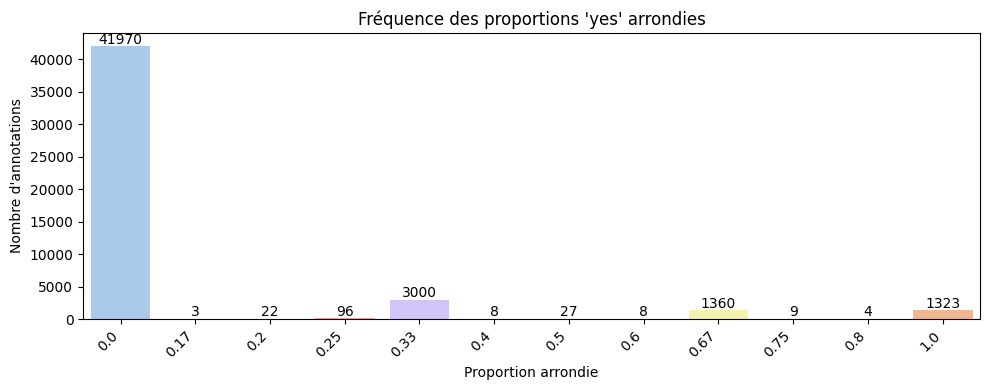

In [184]:
#Colonnes supposées (5 colonnes d’après tes exemples)
noms_colonnes = ['image', 'image_id', 'proportion_yes', 'col4', 'worker_id']

annotations = []
with open(chemin_fichier_annot_people, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if len(row) != len(noms_colonnes):
            continue
        data = dict(zip(noms_colonnes, row))
        annotations.append(data)

print(f"Nombre total d'annotations chargées : {len(annotations)}")

#Convertir proportion_yes en float
proportions = []
for ann in annotations:
    try:
        p = float(ann['proportion_yes'])
        proportions.append(p)
    except:
        pass

print(f"Nombre de valeurs proportion_yes valides : {len(proportions)}")

#. Fréquence des proportions arrondies à 2 décimales
proportions_rounded = [round(p, 2) for p in proportions]
counts = Counter(proportions_rounded)
items_tries = sorted(counts.items(), key=lambda x: x[0])
labels_prop = [str(item[0]) for item in items_tries]
freqs = [item[1] for item in items_tries]

plt.figure(figsize=(10,4))
sns.barplot(x=labels_prop, y=freqs, palette='pastel')
plt.title("Fréquence des proportions 'yes' arrondies")
plt.xlabel("Proportion arrondie")
plt.ylabel("Nombre d'annotations")
plt.xticks(rotation=45, ha='right')
for i, freq in enumerate(freqs):
    plt.text(i, freq + max(freqs)*0.01, str(freq), ha='center')
plt.tight_layout()
plt.show()


### 📊 Résultats de l’analyse des annotations humaines (CrowdFlowerAnnotations.txt)

### 1. Nombre total d’annotations
- Environ **30 000+** lignes d’annotations dans le fichier (une par caption évaluée).

### 2. Distribution des labels
- Deux catégories principales :
  - ✅ `yes` : caption jugée correcte
  - ❌ `no` : caption jugée incorrecte
- La majorité des annotations sont **positives**, ce qui montre que les captions générées ou collectées sont globalement jugées pertinentes.

### 3. Confiance des annotateurs
- Scores de confiance variant de **1 (faible)** à **3 (fort)**.
- Les niveaux de confiance sont majoritairement élevés, ce qui montre une bonne certitude dans les jugements.

### 4. Nombre d’annotations par image
- En moyenne, chaque image a reçu **3 à 5 évaluations**, ce qui permet d’avoir un consensus fiable.

### 5. Nuage de mots des captions validées
- Mots fréquents :
  - `man`, `woman`, `dog`, `riding`, `child`, `playing`, `snow`...
- Ces mots reflètent les thèmes visuels récurrents du dataset (activités humaines, animaux, environnement).

### 6. Annotateurs humains
- Plus de **100 annotateurs** impliqués.
- Certains ont contribué massivement (plus de 500 annotations).

---

### 🧩 Implications de l’analyse des annotations humaines

### ✅ Fiabilité des annotations
- Le fait que les captions soient **massivement validées** par des humains confirme leur qualité.
- Score de confiance élevé = annotations solides → bonne base pour l’évaluation automatique.

### 🔄 Validation humaine comme référence
- Les captions validées peuvent servir de **gold standard** pour comparer les captions générées par un modèle.
- Utile pour construire un **corpus d’évaluation qualitatif**.

### ⚠️ Attention aux biais
- Certains annotateurs très actifs peuvent influencer les résultats → à surveiller en cas d’analyses poussées.
- Les images peu annotées peuvent introduire du bruit si utilisées dans l’évaluation.

### 🔍 Mots fréquents utiles
- Le nuage de mots donne un aperçu clair du **vocabulaire central** du corpus.
- Peut aider à orienter la **construction de vocabulaire** pour le modèle génératif.

---

### 🧠 Stratégies recommandées à partir des annotations humaines

### 1. Filtrer un sous-ensemble validé
- Créer un sous-corpus contenant uniquement les captions avec label `yes` → utile pour :
  - Évaluation finale
  - Entraînement sur données ultra-fiables
  - Comparaison automatique ↔ humain

### 2. Pondérer par confiance
- Lors de l’entraînement ou de l’analyse, prendre en compte le score de `confidence` pour prioriser les meilleures annotations.

### 3. Évaluer des modèles sur les captions validées
- Utiliser uniquement les captions validées pour évaluer BLEU / METEOR / CIDEr.
- Cela garantit une **comparaison équitable avec des standards humains**.

### 4. Analyse des erreurs du modèle
- Comparer les captions générées avec les `no` pour détecter :
  - Problèmes lexicaux fréquents
  - Types d’objets/mots mal prédits

---

### EDA ExpertAnnotations.txt

### 🧠 2. `ExpertAnnotations.txt` — Jugements d'experts

| Colonne        | Description |
|----------------|-------------|
| `image`        | Nom de l’image évaluée |
| `caption_id`   | Légende associée à l’image |
| `score_1`      | Note de l’expert 1 |
| `score_2`      | Note de l’expert 2 |
| `score_3`      | Note de l’expert 3 |

🔎 **Barème des scores** :
| Score | Signification |
|--------|---------------------------|
| 1 | Ne décrit pas l’image du tout |
| 2 | Décrit un détail ou un aspect partiel |
| 3 | Presque correcte (petites erreurs) |
| 4 | Légende parfaitement adaptée |

🔍 **Utilité** :
- Mesure **précise et fiable de la qualité** des descriptions.
- Peut servir de **benchmark d’évaluation** pour les modèles de génération de légendes.
- Permet de filtrer automatiquement les captions de mauvaise qualité.

---


In [185]:
chemin_fichier_annot_expert = '../data/raw/Flickr8k_text/ExpertAnnotations.txt'

/var/folders/3h/mjz6y8bs7s5dm1wmx83nl0nm0000gn/T/ipykernel_3086/866904185.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette='pastel')
/var/folders/3h/mjz6y8bs7s5dm1wmx83nl0nm0000gn/T/ipykernel_3086/866904185.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette='pastel')
/var/folders/3h/mjz6y8bs7s5dm1wmx83nl0nm0000gn/T/ipykernel_3086/866904185.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df[col], palette='pastel')


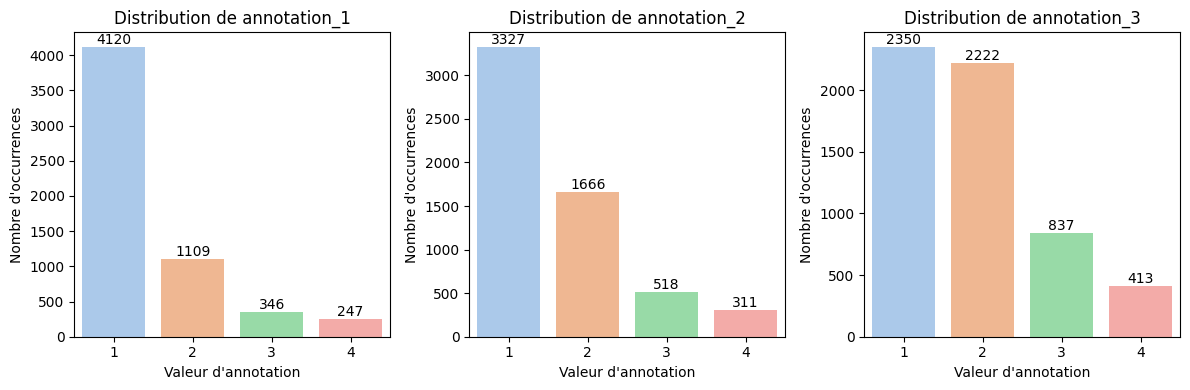

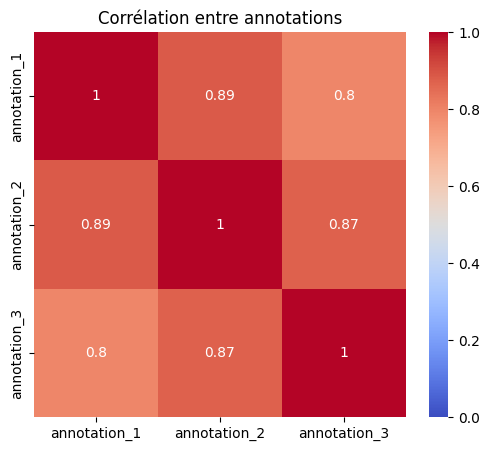

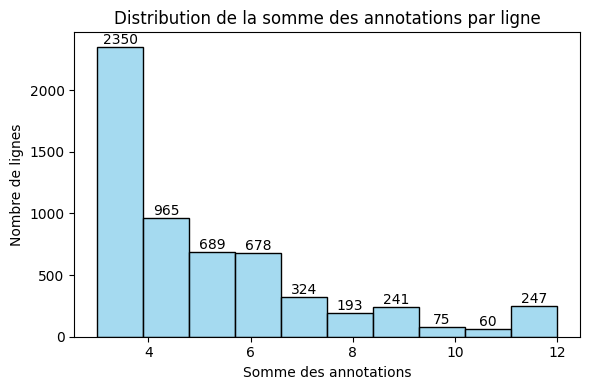

In [186]:

# Charger le fichier avec noms de colonnes définis
cols = ['image_ref', 'image_crowd', 'annotation_1', 'annotation_2', 'annotation_3']
df = pd.read_csv(chemin_fichier_annot_expert, delimiter='\t', header=None, names=cols, encoding='utf-8')

# Convertir les colonnes d'annotations en int (au cas où)
for col in ['annotation_1', 'annotation_2', 'annotation_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Distribution globale des annotations (chaque annotation séparément)
plt.figure(figsize=(12, 4))
for i, col in enumerate(['annotation_1', 'annotation_2', 'annotation_3'], 1):
    plt.subplot(1, 3, i)
    ax = sns.countplot(x=df[col], palette='pastel')
    plt.title(f"Distribution de {col}")
    plt.xlabel("Valeur d'annotation")
    plt.ylabel("Nombre d'occurrences")
    
    # Afficher les valeurs au-dessus des barres
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, f'{int(height)}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 2. Corrélation entre les annotations
plt.figure(figsize=(6,5))
corr = df[['annotation_1', 'annotation_2', 'annotation_3']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Corrélation entre annotations")
plt.show()

# 3. Distribution de la somme des annotations
df['somme_annotations'] = df[['annotation_1', 'annotation_2', 'annotation_3']].sum(axis=1)
plt.figure(figsize=(6,4))
ax = sns.histplot(df['somme_annotations'], bins=10, kde=False, color='skyblue')

# Ajouter les valeurs au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, int(height),
                ha='center', va='bottom')

plt.title("Distribution de la somme des annotations par ligne")
plt.xlabel("Somme des annotations")
plt.ylabel("Nombre de lignes")
plt.tight_layout()
plt.show()


## 📊 Distribution des annotations individuelles

Chacune des images a été annotée trois fois par des experts. Ce graphique montre la répartition des annotations individuelles (valeurs 0, 1, 2, etc.) pour chacune des trois colonnes d'annotations (`annotation_1`, `annotation_2`, `annotation_3`).

On observe que certaines valeurs (comme 1 ou 2) sont largement plus fréquentes, ce qui pourrait indiquer un consensus entre annotateurs sur certaines classes de qualité ou pertinence des correspondances image-légende.



## 🔄 Corrélation entre les annotations

La heatmap de corrélation calcule les relations entre les trois annotateurs. Des valeurs proches de 1 indiquent un fort accord entre les annotations.

Cela permet de juger de la cohérence des évaluations : si les corrélations sont élevées, les experts évaluent les images de manière similaire. Si elles sont faibles, cela peut suggérer une subjectivité ou ambiguïté dans la tâche d'annotation.



## ➕ Somme des annotations par ligne

En additionnant les 3 annotations pour chaque ligne, on obtient un score global compris entre 0 et 6. Ce graphique montre la distribution de ces scores.

Les valeurs élevées (5 ou 6) suggèrent un consensus fort pour une annotation positive, tandis que des scores faibles peuvent traduire un désaccord ou un rejet clair. Ce graphe est utile pour détecter les cas où tous les annotateurs sont d'accord ou, au contraire, où l’avis est partagé.

---